## 导入数据

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from load_data import *


os.environ['CUDA_VISIBLE_DEVICES'] = '0' #使用 GPU 0
def use_gpu_polite(using_rate=0.6):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = using_rate
    return config

/home/dutir923/wujiaming/anaconda3/envs/tf2/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
# 导入数据，train data 是一个字典， ebd embdding 是词向量矩阵，作为embedding层的初始参数
train_data, test_data, ebd_weights = load_imdb_data()
print(train_data.keys())

Load pickle data from ../data/imdb_data_3col.pkl
Original 134957 words in vocabulary.
After truncated low frequent word:
words num: 40000/134957; words freq: 0.981
Words exit in w2v file: 39210/40004, rate: 98.015198%
Shape of weight matrix: (40006, 50)
Train data shape: (25000, 500) label length: 25000
Test data shape: (25000, 500) label length: 25000
dict_keys(['data', 'data_len', 'label'])


## 两种指数递减的学习率

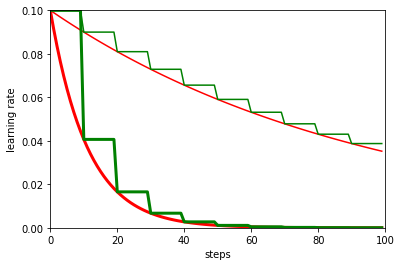

In [3]:
learning_rate = 0.1  # 初始学习率
decay_steps = 10    # 递减步数
decay_rate = 0.9    # 递减率
global_step = tf.Variable(0, trainable=False, dtype=tf.int32)
global_step_op = tf.assign(global_step, global_step+1)

# exp_decay_lr = learning_rate * decay_rate ^ (global_step / decay_step)
exp_decay = tf.train.exponential_decay(learning_rate, global_step, decay_steps, 
                                       decay_rate, staircase=False)
staire_exp_decay = tf.train.exponential_decay(learning_rate, global_step, decay_steps, 
                                       decay_rate, staircase=True)

# nature_exp_decay_lr = learning_rate * exp(-decay_rate * global_step)
nature_exp_decay = tf.train.natural_exp_decay(learning_rate, global_step, decay_steps, 
                                              decay_rate, staircase=False)
staire_nature_exp_decay = tf.train.natural_exp_decay(learning_rate, global_step, decay_steps, 
                                              decay_rate, staircase=True)

step_max = 100
elr_lst = []
selr_lst = []
nelr_lst = []
snelr_lst = []

config = use_gpu_polite()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    step_now = sess.run(global_step)
    while step_now < step_max:
        elr, selr, nelr, snelr = sess.run([exp_decay, staire_exp_decay, nature_exp_decay, 
                                          staire_nature_exp_decay])
        elr_lst.append(elr)
        selr_lst.append(selr)
        nelr_lst.append(nelr)
        snelr_lst.append(snelr)
        step_now = sess.run(global_step_op)
    
x = range(step_max)
plt.plot(x, elr_lst, 'r-')
plt.plot(x, selr_lst, 'g-')
plt.plot(x, nelr_lst, 'r-', linewidth=3)
plt.plot(x, snelr_lst, 'g-', linewidth=3)
plt.ylim([0, learning_rate])
plt.xlim([0, step_max])
plt.xlabel('steps')
plt.ylabel('learning rate')
plt.show()

## 在textCNN中使用指数递减学习率

In [4]:
class TextCNN_layer():
    def __init__(self, seq_length, class_num, ebd_weights, filter_num, filter_sizes = [2, 3, 4]):
        seed_num = 7

        self.seq_input = tf.placeholder(dtype=tf.int32, shape=[None, seq_length],
                                        name='sequence_input')
        self.sparse_label_input = tf.placeholder(dtype=tf.int32, shape=[None],
                                                 name='sparse_label')
        self.global_step = tf.Variable(0, trainable=False)
        self.global_step_op = tf.assign(self.global_step, self.global_step+1)
        # 使用动态指数递减学习率
        self.learning_rate = tf.train.exponential_decay(0.0015, self.global_step, decay_steps=10, 
                                       decay_rate=0.9, staircase=True)

        embedding_dim = ebd_weights.shape[1]
        with tf.name_scope('embedding'):
            self.W = tf.Variable(initial_value=ebd_weights, name='W')
            self.embedding_layer = tf.nn.embedding_lookup(self.W, self.seq_input)
            # batch * seq_len * emb_dim * in_channel(1)
            self.embedding_layer_expand = tf.expand_dims(self.embedding_layer, axis=-1)

        pool_layers = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope('conv-maxpool-%s' % i):
                conv = tf.layers.conv2d(self.embedding_layer_expand, filter_num, [filter_size, embedding_dim],
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.1, seed=seed_num),
                                bias_initializer=tf.constant_initializer(0.1),
                                activation='relu', padding='VALID')
                pool = tf.layers.max_pooling2d(conv, pool_size=[seq_length-filter_size+1, 1], 
                                               strides=[1, 1], padding='VALID')
                pool_layers.append(pool)
        
        all_dim = len(filter_sizes) * filter_num
        self.pool_flatten = tf.reshape(tf.concat(pool_layers, -1), shape=[-1, all_dim])
        
        with tf.name_scope('output'):
            self.logits = tf.layers.dense(self.pool_flatten, class_num, 
                                          kernel_initializer=tf.truncated_normal_initializer(seed=seed_num), 
                                          bias_initializer=tf.constant_initializer(0.1))
            self.prediction = tf.argmax(self.logits, axis=-1, output_type=tf.int32, name='prediction')

        with tf.name_scope('loss'):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.sparse_label_input, logits=self.logits)
            self.loss_sum = tf.reduce_sum(losses)
            self.loss = tf.reduce_mean(losses, name='loss')

        with tf.name_scope('accuracy'):
            correct_predction = tf.equal(self.prediction, self.sparse_label_input)
            self.correct_num = tf.reduce_sum(tf.cast(correct_predction, tf.float16), name='accuracy')
            self.accuracy = tf.reduce_mean(tf.cast(correct_predction, tf.float16), name='accuracy')
        
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        gs_vs = optimizer.compute_gradients(self.loss)
        self.train_op = optimizer.apply_gradients(gs_vs)

## 开始训练，注意观察学习率

In [5]:
train_x, train_y = train_data['data'], [1 if i == 'pos' else 0 for i in train_data['label']]
test_x, test_y = test_data['data'], [1 if i == 'pos' else 0 for i in test_data['label']]
cnn_model = TextCNN_layer(seq_length=train_x.shape[1], class_num=2, ebd_weights=ebd_weights, filter_num=32)
batch_size = 1000
epoch_max = 100


config = use_gpu_polite()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    epoch_now = sess.run(cnn_model.global_step)
    
    while epoch_now < epoch_max:
        # 在训练集上按batch训练完所有，算作一个epoch
        batch_num = train_x.shape[0] // batch_size
        for i in range(batch_num+1):
            s_i = i * batch_size
            e_i = min((i+1)*batch_size, train_x.shape[0])
            if s_i >= e_i:
                continue
            in_x, in_y = train_x[s_i: e_i, :], train_y[s_i: e_i]
            feed_dict = {cnn_model.seq_input: in_x, cnn_model.sparse_label_input: in_y}
            sess.run(cnn_model.train_op, feed_dict)

        epoch_now = sess.run(cnn_model.global_step_op)  # 跑完了一个epoch，epoch+1
        
        if epoch_now % 10 == 0:  # 每10轮观察一下训练集测试集loss 和 acc
            # 训练集总的损失和acc也要分步测，否则内存不够
            batch_num = train_x.shape[0] // batch_size
            train_total_loss = 0
            train_total_correct = 0
            for i in range(batch_num+1):
                s_i = i * batch_size
                e_i = min((i+1)*batch_size, train_x.shape[0])
                if s_i >= e_i:
                    continue
                in_x, in_y = train_x[s_i: e_i, :], train_y[s_i: e_i]
                feed_dict = {cnn_model.seq_input: in_x, cnn_model.sparse_label_input: in_y}

                train_loss_one, train_correct_one = sess.run([cnn_model.loss_sum, cnn_model.correct_num], feed_dict)
                train_total_loss += train_loss_one
                train_total_correct += train_correct_one
            train_loss = train_total_loss / train_x.shape[0]
            train_acc = train_total_correct / train_x.shape[0]

            # 测试集的损失和acc
            batch_num = test_x.shape[0] // batch_size
            test_total_loss = 0
            test_total_correct = 0
            for i in range(batch_num+1):
                s_i = i * batch_size
                e_i = min((i+1)*batch_size, test_x.shape[0])
                if s_i >= e_i:
                    continue
                in_x, in_y = test_x[s_i: e_i, :], test_y[s_i: e_i]
                feed_dict = {cnn_model.seq_input: in_x, cnn_model.sparse_label_input: in_y}

                test_loss_one, test_correct_one = sess.run([cnn_model.loss_sum, cnn_model.correct_num], feed_dict)
                test_total_loss += test_loss_one
                test_total_correct += test_correct_one
            test_loss = test_total_loss / test_x.shape[0]
            test_acc = test_total_correct / test_x.shape[0]
            
            lr_now = sess.run(cnn_model.learning_rate)
            print('Epoch %d, train loss %.4f, acc %.4f; test loss %.4f, acc %.4f. lr: %f' % 
                  (epoch_now, train_loss, train_acc, test_loss, test_acc, lr_now))


Epoch 10, train loss 5.5135, acc 0.6188; test loss 6.3615, acc 0.5951. lr: 0.001350
Epoch 20, train loss 2.4943, acc 0.7309; test loss 3.6131, acc 0.6704. lr: 0.001215
Epoch 30, train loss 0.8683, acc 0.8510; test loss 2.0620, acc 0.7397. lr: 0.001093
Epoch 40, train loss 0.2913, acc 0.9330; test loss 1.4953, acc 0.7735. lr: 0.000984
Epoch 50, train loss 0.0969, acc 0.9789; test loss 1.2828, acc 0.7850. lr: 0.000886
Epoch 60, train loss 0.0464, acc 0.9899; test loss 1.2625, acc 0.7812. lr: 0.000797
Epoch 70, train loss 0.0245, acc 0.9960; test loss 1.2528, acc 0.7805. lr: 0.000717
Epoch 80, train loss 0.0149, acc 0.9984; test loss 1.2479, acc 0.7790. lr: 0.000646
Epoch 90, train loss 0.0101, acc 0.9992; test loss 1.2454, acc 0.7791. lr: 0.000581
Epoch 100, train loss 0.0074, acc 0.9996; test loss 1.2438, acc 0.7798. lr: 0.000523


**先观察了一下两种指数下降学习率的两种方法，可以设置是否阶梯形式。还有其他类型的动态衰减学习率：多项式、倒数、余弦。自行查阅**  
**然后在textcnn模型中使用指数衰减学习率，观察训练效果，和之前的进行比较。**